# Conceptular Synthesis Experiment 1: Resynthesis of a snare drum sample - Effects of N and Pattern Size

In [102]:
%pylab inline
from IPython.display import Audio
import librosa
import scipy 
import uuid
from scipy import signal

figsize(20,6)

Populating the interactive namespace from numpy and matplotlib


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['csd', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [103]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights



In [104]:
y, sr = librosa.load("audios/snare.wav", sr=22050)
y = y[20:]


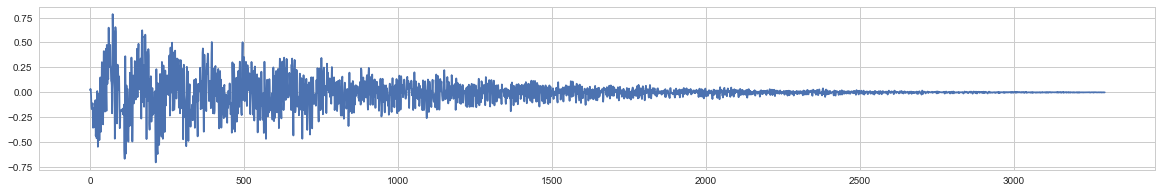

In [105]:
import seaborn as sns
sns.set(style="whitegrid")
figsize(20,3)
plot(y)


In [106]:
Audio(data=y[:],rate=sr)

In [7]:
def computeConceptor(net, i_pattern, alpha):
#     print('Computing conceptor, alpha: ', alpha)
    Cs = np.zeros(4, dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = S.dot(linalg.inv(S + pow(alpha, -2) * np.eye(net['p']['N'])))

    C =  U.dot(Snew).dot(U.T);
    Cs[0] = C
    Cs[1] = U
    Cs[2] = diag(Snew)
    Cs[3] = diag(S)

    return Cs


def testConceptor(net, cs, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
    C = cs[0]
    for i_trial in range(trials):
        x_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        z_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        x = 0.5 * np.random.randn(net['p']['N'],1) * 0.0
        z = x
        for n in range(recallTestLength + net['p']['washoutLength']):
            xOld = x
            Wtarget = (net['W'].dot(x))
            z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
            x = C.dot(z)
            xPrev = x
            if (n > net['p']['washoutLength']):
                x_CTestPL[:,n-net['p']['washoutLength']] = x.T
                z_CTestPL[:,n-net['p']['washoutLength']] = z.T

        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)


def plotConceptorPattern(net, cs, recallTestLength, i_pattern):
    x_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    z_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    p_CTestPL = np.zeros((1, recallTestLength, net['p']['patts'].shape[0]))
    C = cs[0]
    x = 0.5 * np.random.randn(net['p']['N'],1) * 0
    z = x
    for n in range(recallTestLength + net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        xPrev = x
        if (n > net['p']['washoutLength']):
            x_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
    outputPattern = p_CTestPL[:,:,i_pattern][0]
    targetPattern = np.array([net['p']['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    templateScan = np.correlate(outputPattern[:net['p']['patts'][i_pattern].size*2],net['p']['patts'][i_pattern])
    matchPoint = np.argmax(templateScan)
    if (matchPoint > 0):
        outputPattern = outputPattern[matchPoint:]
        targetPattern = targetPattern[:-matchPoint]
    score = nrmse(outputPattern, targetPattern) 
#     print(score)
#     plot(outputPattern)
#     plot(targetPattern)
    return score

def render(net, pcs, winSize, cMod=1.0, lrMod=1.0, alphaMod=1.0, speed=1.0):
    speed = 1.0/speed
    audio = np.zeros(0)
    x = 0.5 * np.random.randn(net['p']['N'],1)
    C = pcs[0][0]
    LR = net['p']['LR'] * lrMod
    orgW = net['W']
    Wmod = orgW * alphaMod
    #run to washout
    for n in range(net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        
    for n in range(int(winSize * pcs.shape[0] * abs(speed))):
        currConceptor = int(n/abs(speed) / winSize)
        if (speed <= 0):
            currConceptor = pcs.shape[0] - currConceptor - 1  #reverse
        C = pcs[currConceptor][0] * cMod
        xOld = x
        Wtarget = (Wmod.dot(x))
        z = ((1.0 - LR) * xOld) + (LR * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        newSample = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
        audio = np.concatenate((audio, newSample))
    return audio



In [7]:
%%time
#create a random reservoir and load it with patterns using Jaeger's method
def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, p['learnLength'] * p['patts'].shape[0]));
    allTrainOldxArgs = np.zeros((p['N'], p['learnLength'] * p['patts'].shape[0]));
    allTrainWtargets = np.zeros((p['N'], p['learnLength'] * p['patts'].shape[0]));
    allTrainOuts = np.zeros((1, p['learnLength'] * p['patts'].shape[0]));
    patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
    for i_pattern in range(p['patts'].shape[0]):
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt.take(n, mode='wrap')
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        storeBegin = i_pattern * p['learnLength']
        storeEnd = (i_pattern * p['learnLength']) + p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs[:,storeBegin : storeEnd ] = xCollector
        allTrainOldxArgs[:,storeBegin : storeEnd ] = xOldCollector
        allTrainOuts[:,storeBegin : storeEnd ] = pCollector
        allTrainWtargets[:,storeBegin : storeEnd ]  = WTargetCollector


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
#     print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
#     print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
#     print("NRMSE W: ", NRMSE_W, " :: ", end='')
#     print("absSize W: ", absSize_W)

    data ={k: v for k, v in locals().items() if k in 
           ('p','Win','Wstar', 'Wbias','NRMSE_W', 'absSize_W','patternRs','W',
            'Wout','NRMSE_readout', 'absSize_readout')}
    return data

    


    


def testModel(params, windowSize):
    
    simpleParams = {k: v for k, v in params.items() if k not in ('patts')}
    testResults = {"p":simpleParams,"windowSize":windowSize}
    sampleSize = 10
    print(simpleParams)
    loadedNets = np.zeros(sampleSize, dtype=np.object)
    for i_net, net in enumerate(loadedNets):
        print(i_net, ".", end='')
        loadedNets[i_net] = makeLoadedNetwork_v2(params)
    nrmses = [x['NRMSE_readout'] for x in loadedNets]
    bestNetwork = np.argmin(nrmses)
    print("\nNRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_readout'], "avg: ", np.mean(nrmses) )
    testResults["loading error"] = loadedNets[bestNetwork]['NRMSE_readout']
    def fitnessf(aperture, *args):
        print(args[0], ".", end='')
        cs = computeConceptor(loadedNets[bestNetwork], args[0], aperture)
        atten = testConceptor(loadedNets[bestNetwork], cs, windowSize*4)
        return atten

    apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=0, xtol=1, args = (x,)) 
                 for x in np.arange(params['patts'].shape[0])]

    patternCs = np.zeros(len(apertures), dtype=np.object)
    scores = np.zeros(len(apertures))
    for i_patt in range(len(apertures)):
        print(i_patt,".",end='')
        patternCs[i_patt] = computeConceptor(loadedNets[bestNetwork], i_patt, apertures[i_patt])
        scores[i_patt] = plotConceptorPattern(loadedNets[bestNetwork], patternCs[i_patt], windowSize * 5, i_patt)

    print('\nScore: ',np.mean(scores))
    testResults["recon scores"] = scores
#     testResults["net"] = loadedNets[bestNetwork]
#     testResults["Cs"] = patternCs
    audio = render(loadedNets[bestNetwork], patternCs, windowSize, 1.0, 1.0, 1, 1.0)
    testResults["reconScore"] = nrmse(audio, y[:audio.size])
    librosa.output.write_wav("results/patternSize_N/snare_patternsize_" + str(windowSize) + "N_" + str(params["N"]) + "--" + str(uuid.uuid4()) + ".wav", audio, sr)
    testResults["audio"] = audio
    print("Recon score: ", testResults["reconScore"])
    return testResults


allResults = []
Ws = [5,15,25,35,45,55,65] 
Ns = [200,400,600,800,1000]
# Ws = [5,10] 
for v_n in Ns:
    for v_w in Ws:
        for i in range(5):
            windowSize=v_w
            padding = windowSize - (y.size % windowSize)
            y = np.concatenate((y, np.zeros(padding)))
            nWindows = int(y.size/windowSize)
            print(y.shape, nWindows)
            #divide out windows
            patterns = np.zeros((nWindows, windowSize))
            for i in range(nWindows):
                patterns[i] = y[i*windowSize : (i+1) * windowSize]

            p = {'N':v_n, 'NetSR':1.5, 'NetinpScaling':1.2,'BiasScaling':0.5,'TychonovAlpha':0.0001,
                     'washoutLength':windowSize*4, 'learnLength':windowSize * 4, 'TychonovAlphaReadout':0.001,
                      'LR': 0.99,
                       'patts':patterns[np.arange(int(1500/windowSize))]
                     }
            res = testModel(p, windowSize)
            allResults = append(allResults, res)


(3300,) 660
{'learnLength': 20, 'TychonovAlpha': 0.0001, 'LR': 0.99, 'washoutLength': 20, 'NetSR': 1.5, 'TychonovAlphaReadout': 0.001, 'BiasScaling': 0.5, 'N': 200, 'NetinpScaling': 1.2}
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.00529462500351 avg:  0.037671891495
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 

256 .256 .256 .256 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .258 .258 .258 .258 .258 .258 .258 .258 .258 .258 .258 .259 .259 .259 .259 .259 .259 .259 .259 .259 .259 .259 .259 .259 .260 .260 .260 .260 .260 .260 .260 .260 .260 .260 .260 .260 .260 .260 .260 .261 .261 .261 .261 .261 .261 .261 .261 .261 .261 .261 .261 .261 .261 .261 .262 .262 .262 .262 .262 .262 .262 .262 .262 .262 .262 .262 .262 .262 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .264 .264 .264 .264 .264 .264 .264 .264 .264 .264 .264 .264 .265 .265 .265 .265 .265 .265 .265 .265 .265 .265 .265 .265 .265 .266 .266 .266 .266 .266 .266 .266 .266 .266 .266 .266 .266 .266 .266 .266 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .268 .268 .268 .268 .268 .268 .268 .268 .268 .268 .268 .268 .268 .268 .268 .269 .269 .269 .269 .269 .269 .269 .269 .269 .269 .269 .269 .269 .269 .269 .270 .270 .270 .270 .270 .270 .270 .270 .270 .270 .270 .270 .270 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 

270 .270 .270 .270 .270 .270 .270 .270 .270 .271 .271 .271 .271 .271 .271 .271 .271 .271 .271 .271 .271 .272 .272 .272 .272 .272 .272 .272 .272 .272 .272 .272 .272 .272 .273 .273 .273 .273 .273 .273 .273 .273 .273 .273 .273 .273 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .277 .277 .277 .277 .277 .277 .277 .277 .277 .277 .277 .277 .277 .277 .277 .278 .278 .278 .278 .278 .278 .278 .278 .278 .278 .278 .278 .278 .278 .278 .279 .279 .279 .279 .279 .279 .279 .279 .279 .279 .279 .279 .279 .280 .280 .280 .280 .280 .280 .280 .280 .280 .280 .280 .280 .280 .280 .281 .281 .281 .281 .281 .281 .281 .281 .281 .281 .281 .281 .282 .282 .282 .282 .282 .282 .282 .282 .282 .282 .282 .282 .282 .282 .283 .283 .283 .283 .283 .283 .283 .283 .283 .283 .283 .283 .283 .283 .284 .284 .284 .284 .284 .284 .284 .284 .284 .284 .284 .284 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 

0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0069706856465 avg:  0.0460430761254
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 

0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.00993087240096 avg:  0.0511066261744
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .1

232 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 

244 .244 .244 .244 .244 .244 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .251 .251 .251 .251 .251 .251 .251 .251 .251 .251 .251 .251 .251 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .255 .255 .255 .255 .255 .255 .255 .255 .255 .255 .255 .255 .255 .255 .255 .256 .256 .256 .256 .256 .256 .256 .256 .256 .256 .256 .256 .256 .256 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .257 .258 .258 .258 .258 .258 .258 .258 .258 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .1

0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0101000361762 avg:  0.0339100426829
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 

227 .227 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .240 .240 .240 .240 .240 .240 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 

231 .231 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .244 .244 .244 .244 .244 .244 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .23 .23 .23 .

0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.00930803131427 avg:  0.028524176583
0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .

0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.01385411233 avg:  0.0268264721433
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .

227 .227 .227 .227 .227 .227 .227 .227 .227 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 

234 .234 .234 .234 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .1

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .23 .23 .23 .23 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18

126 .126 .126 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .

231 .231 .231 .231 .231 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .244 .244 .244 .244 .244 .244 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 

228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

227 .227 .227 .227 .227 .227 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .240 .240 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .1

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .2

In [107]:
# import dill as pickle
# with open(r"results/expt1VaryingPatternSize_N.pickled", "wb") as output_file:    
#     pickle.dump(allResults, output_file, protocol=0)

# import dill as pickle
# with open(r"results/expt1VaryingPatternSize_N.pickled", "rb") as in_file:    
#     allResults = pickle.load(in_file)

In [109]:
# a = np.array([[x['p']['learnLength']/4, x['p']['N'], np.mean(x['recon scores'])] for x in allResults if x['p']['N'] !=0])
a = np.array([[x['p']['learnLength']/4, x['p']['N'], x['reconScore']] for x in allResults if x['p']['N'] !=0])

In [110]:
a

array([[  5.00000000e+00,   2.00000000e+02,   1.01858987e+00],
       [  5.00000000e+00,   2.00000000e+02,   1.01305955e+00],
       [  5.00000000e+00,   2.00000000e+02,   1.03883930e+00],
       [  5.00000000e+00,   2.00000000e+02,   1.01753988e+00],
       [  5.00000000e+00,   2.00000000e+02,   1.02236385e+00],
       [  1.50000000e+01,   2.00000000e+02,   1.11611852e+00],
       [  1.50000000e+01,   2.00000000e+02,   1.15438067e+00],
       [  1.50000000e+01,   2.00000000e+02,   1.22435984e+00],
       [  1.50000000e+01,   2.00000000e+02,   1.19666011e+00],
       [  1.50000000e+01,   2.00000000e+02,   1.24334117e+00],
       [  2.50000000e+01,   2.00000000e+02,   1.20941099e+00],
       [  2.50000000e+01,   2.00000000e+02,   1.16546904e+00],
       [  2.50000000e+01,   2.00000000e+02,   1.23705288e+00],
       [  2.50000000e+01,   2.00000000e+02,   1.15173848e+00],
       [  2.50000000e+01,   2.00000000e+02,   1.17038759e+00],
       [  3.50000000e+01,   2.00000000e+02,   1.3006294

In [111]:
a[:,0]

array([  5.,   5.,   5.,   5.,   5.,  15.,  15.,  15.,  15.,  15.,  25.,
        25.,  25.,  25.,  25.,  35.,  35.,  35.,  35.,  35.,  45.,  45.,
        45.,  45.,  45.,  55.,  55.,  55.,  55.,  55.,  65.,  65.,  65.,
        65.,  65.,   5.,   5.,   5.,   5.,   5.,  15.,  15.,  15.,  15.,
        15.,  25.,  25.,  25.,  25.,  25.,  35.,  35.,  35.,  35.,  35.,
        45.,  45.,  45.,  45.,  45.,  55.,  55.,  55.,  55.,  55.,  65.,
        65.,  65.,  65.,  65.,   5.,   5.,   5.,   5.,   5.,  15.,  15.,
        15.,  15.,  15.,  25.,  25.,  25.,  25.,  25.,  35.,  35.,  35.,
        35.,  35.,  45.,  45.,  45.,  45.,  45.,  55.,  55.,  55.,  55.,
        55.,  65.,  65.,  65.,  65.,  65.,   5.,   5.,   5.,   5.,   5.,
        15.,  15.,  15.,  15.,  15.,  25.,  25.,  25.,  25.,  25.,  35.,
        35.,  35.,  35.,  35.,  45.,  45.,  45.,  45.,  45.,  55.,  55.,
        55.,  55.,  55.,  65.,  65.,  65.,  65.,  65.,   5.,   5.,   5.,
         5.,   5.,  15.,  15.,  15.,  15.,  15.,  2

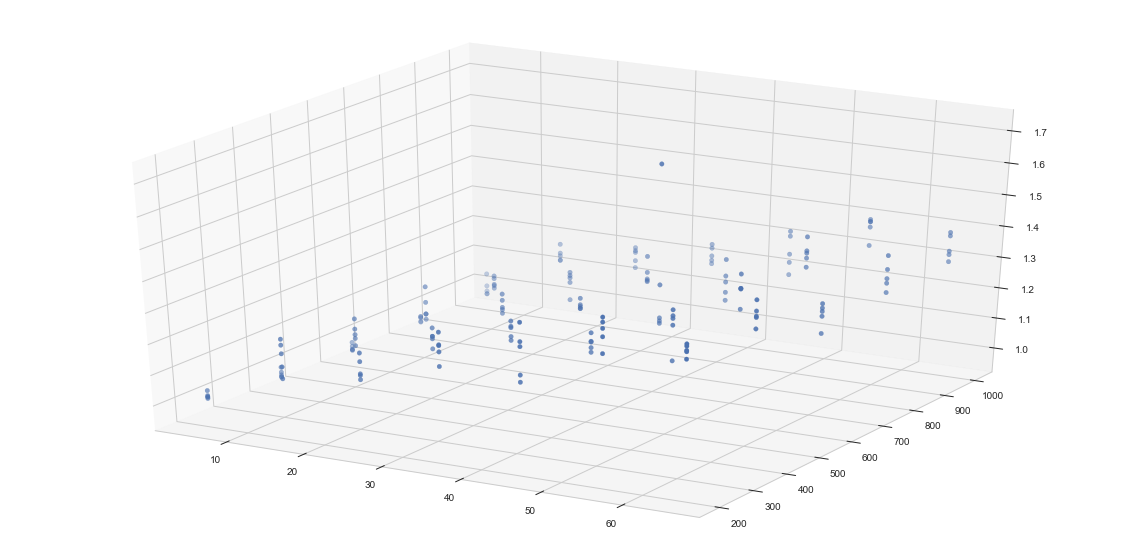

In [112]:
from mpl_toolkits.mplot3d import Axes3D
figsize(20,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a[:,0], a[:,1], a[:,2])

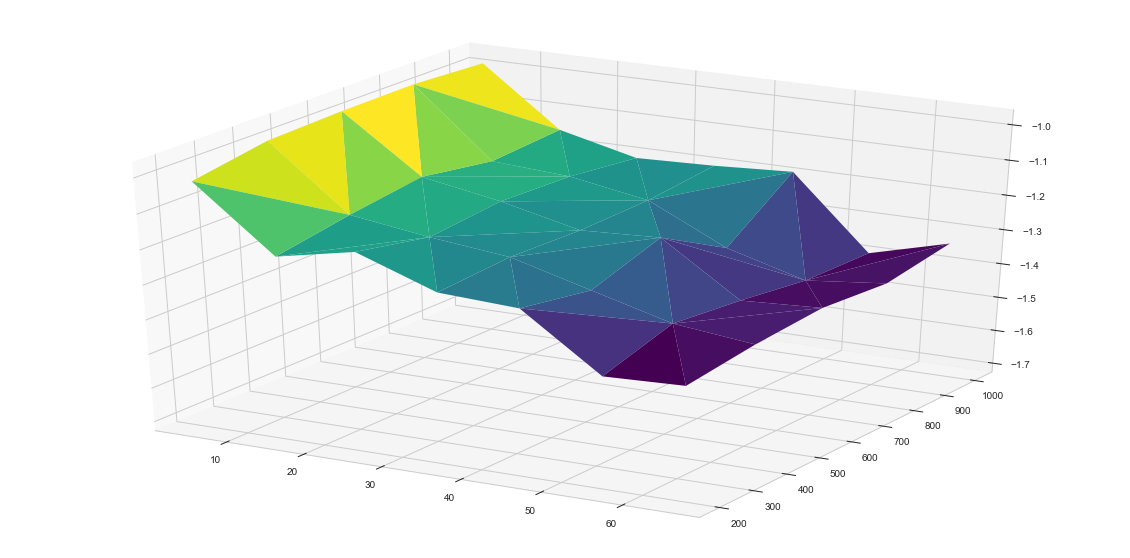

In [113]:
from mpl_toolkits.mplot3d import Axes3D
figsize(20,10)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(a[:,0], a[:,1], -a[:,2], cmap=plt.cm.viridis)

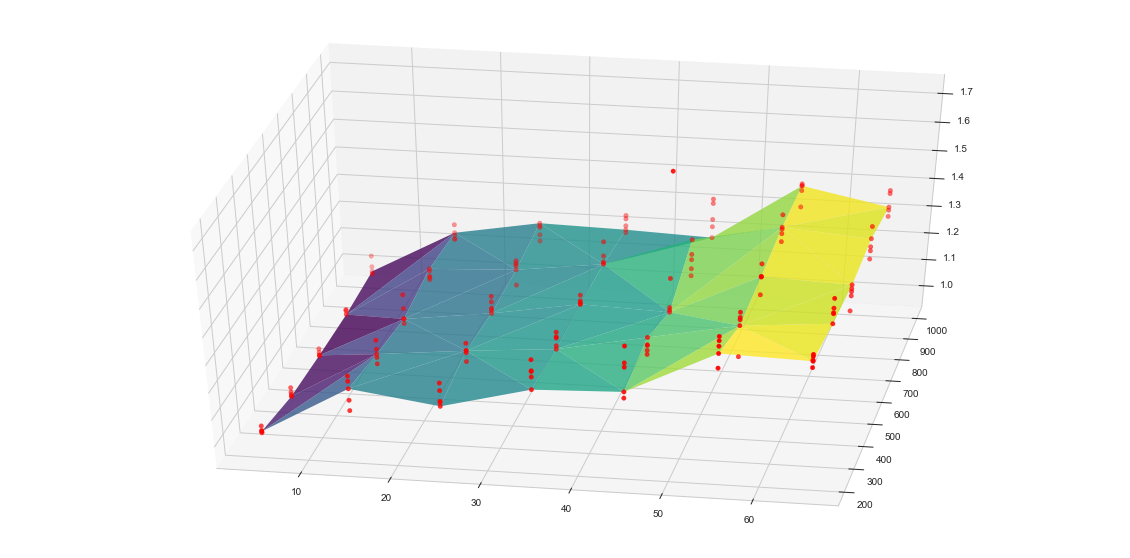

In [114]:
from mpl_toolkits.mplot3d import Axes3D
figsize(20,10)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=40, azim=280)
ax.plot_trisurf(a[:,0], a[:,1], a[:,2], cmap=plt.cm.viridis, shade=False, alpha=0.8)
ax.scatter(a[:,0], a[:,1], a[:,2], color='red')
plt.savefig('surface.png')

In [115]:
# Ws = [5,10] 

Ws = [5,15,25,35,45,55,65] 
Ns = [200,400,600,800,1000]
avgs = np.zeros((len(Ws) * len(Ns),3))
idx=0
for v_n in Ns:
    for v_w in Ws:
        g = [v_n, v_w, np.mean([x[2] for x in a if x[0]==v_w and x[1] == v_n])]
        print(g)
        avgs[idx] = g
        idx=idx+1

[200, 5, 1.0220784906563414]
[200, 15, 1.18697206140155]
[200, 25, 1.1868117971526593]
[200, 35, 1.2899482083648508]
[200, 45, 1.3106953090577442]
[200, 55, 1.4164132891477341]
[200, 65, 1.3968650299335004]
[400, 5, 0.99441558018356579]
[400, 15, 1.1650089237126564]
[400, 25, 1.1884538886508151]
[400, 35, 1.2490844293245369]
[400, 45, 1.2456572460031272]
[400, 55, 1.3371180659214956]
[400, 65, 1.4093559371501343]
[600, 5, 0.98288875524915564]
[600, 15, 1.1544820374081155]
[600, 25, 1.1988077281124025]
[600, 35, 1.2340847055020137]
[600, 45, 1.342077594022534]
[600, 55, 1.3561066088522906]
[600, 65, 1.3141809952680406]
[800, 5, 0.98335310556070077]
[800, 15, 1.1424569191762219]
[800, 25, 1.1814842577199252]
[800, 35, 1.2422835738089553]
[800, 45, 1.2516450739230702]
[800, 55, 1.3798150654411265]
[800, 65, 1.3429165819545275]
[1000, 5, 0.99582747383831549]
[1000, 15, 1.1436577150911764]
[1000, 25, 1.1751224929510273]
[1000, 35, 1.2146240819188949]
[1000, 45, 1.2585660638705058]
[1000, 55

In [116]:
avgs

array([[  2.00000000e+02,   5.00000000e+00,   1.02207849e+00],
       [  2.00000000e+02,   1.50000000e+01,   1.18697206e+00],
       [  2.00000000e+02,   2.50000000e+01,   1.18681180e+00],
       [  2.00000000e+02,   3.50000000e+01,   1.28994821e+00],
       [  2.00000000e+02,   4.50000000e+01,   1.31069531e+00],
       [  2.00000000e+02,   5.50000000e+01,   1.41641329e+00],
       [  2.00000000e+02,   6.50000000e+01,   1.39686503e+00],
       [  4.00000000e+02,   5.00000000e+00,   9.94415580e-01],
       [  4.00000000e+02,   1.50000000e+01,   1.16500892e+00],
       [  4.00000000e+02,   2.50000000e+01,   1.18845389e+00],
       [  4.00000000e+02,   3.50000000e+01,   1.24908443e+00],
       [  4.00000000e+02,   4.50000000e+01,   1.24565725e+00],
       [  4.00000000e+02,   5.50000000e+01,   1.33711807e+00],
       [  4.00000000e+02,   6.50000000e+01,   1.40935594e+00],
       [  6.00000000e+02,   5.00000000e+00,   9.82888755e-01],
       [  6.00000000e+02,   1.50000000e+01,   1.1544820

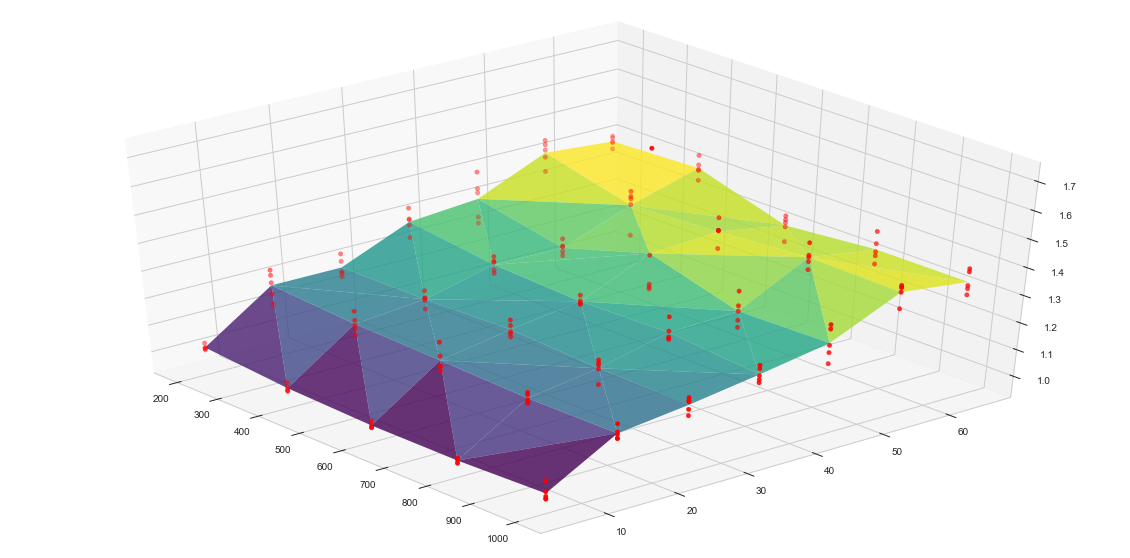

In [120]:
from mpl_toolkits.mplot3d import Axes3D
figsize(20,10)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=40, azim=-40)
ax.plot_trisurf(avgs[:,0], avgs[:,1], avgs[:,2], cmap=plt.cm.viridis, shade=False, alpha=0.8)
ax.scatter(a[:,1], a[:,0], a[:,2], color='red')
plt.savefig('surface.png')

In [106]:
a

array([[  5.00000000e+00,   2.00000000e+02,   8.65589127e-01],
       [  5.00000000e+00,   2.00000000e+02,   8.77074979e-01],
       [  5.00000000e+00,   2.00000000e+02,   6.43555499e-01],
       [  5.00000000e+00,   2.00000000e+02,   9.18532528e-01],
       [  5.00000000e+00,   2.00000000e+02,   8.66787793e-01],
       [  1.50000000e+01,   2.00000000e+02,   1.11807334e+00],
       [  1.50000000e+01,   2.00000000e+02,   1.26141152e+00],
       [  1.50000000e+01,   2.00000000e+02,   1.30151207e+00],
       [  1.50000000e+01,   2.00000000e+02,   1.01430136e+00],
       [  1.50000000e+01,   2.00000000e+02,   1.08118359e+00],
       [  2.50000000e+01,   2.00000000e+02,   1.41773539e+00],
       [  2.50000000e+01,   2.00000000e+02,   1.54868833e+00],
       [  2.50000000e+01,   2.00000000e+02,   1.37997923e+00],
       [  2.50000000e+01,   2.00000000e+02,   1.34742958e+00],
       [  2.50000000e+01,   2.00000000e+02,   1.38224983e+00],
       [  3.50000000e+01,   2.00000000e+02,   1.4277580

In [92]:
Ws = [5,15,25,35,45,55,65] 
Ns = [200,400,600,800,1000]
avgs = np.zeros((len(Ws) * len(Ns),3))
idx=0
for v_n in Ns:
    for v_w in Ws:
        g = [v_n, v_w, np.mean([x[2] for x in b if x[0]==v_w and x[1] == v_n])]
        print(g)
        avgs[idx] = g
        idx=idx+1

[200, 5, 0.78455199524725283]
[200, 15, 0.88231322271630597]
[200, 25, 0.87215425167321159]
[200, 35, 0.89126591432562807]
[200, 45, 0.88922934567530443]
[200, 55, 0.89529112303428116]
[200, 65, 0.88194062719738597]
[400, 5, 0.78499815695738917]
[400, 15, 0.87123569881963392]
[400, 25, 0.86837410164601114]
[400, 35, 0.88611159338254475]
[400, 45, 0.88384687182590937]
[400, 55, 0.88115755667613005]
[400, 65, 0.90250696431459265]
[600, 5, 0.78790904413249718]
[600, 15, 0.86850641988107691]
[600, 25, 0.86756772187087816]
[600, 35, 0.8694273120177648]
[600, 45, 0.87791730905596954]
[600, 55, 0.89813041553890538]
[600, 65, 0.90080335167339742]
[800, 5, 0.79435297703722862]
[800, 15, 0.86974543687153061]
[800, 25, 0.8693318883163309]
[800, 35, 0.879480740562402]
[800, 45, 0.86781025404019574]
[800, 55, 0.90917192888627552]
[800, 65, 0.89287726277469126]
[1000, 5, 0.78972186883715789]
[1000, 15, 0.85747731745167355]
[1000, 25, 0.85777085601545333]
[1000, 35, 0.87093227469178025]
[1000, 45, 0.

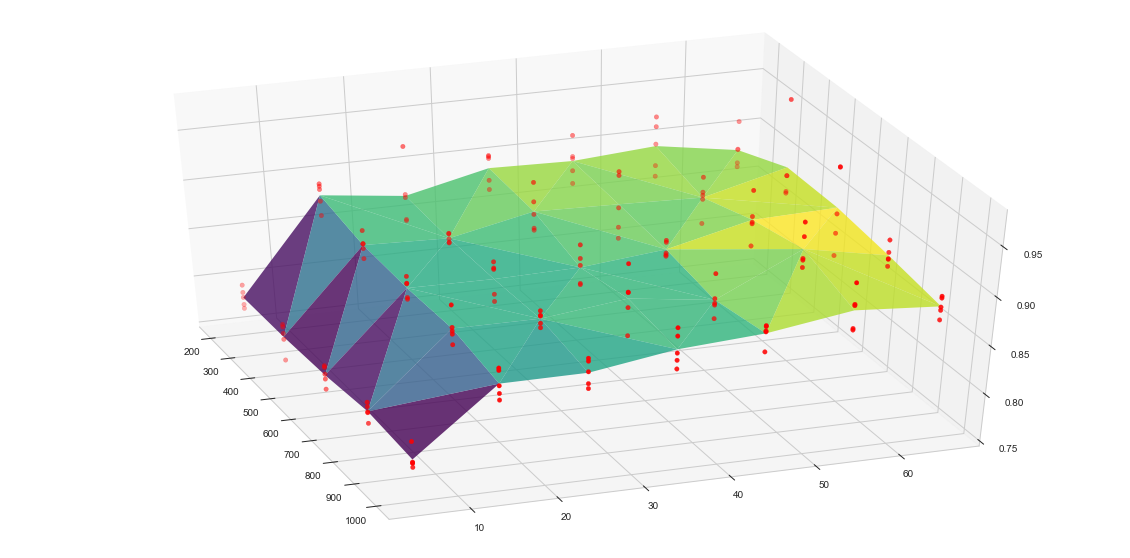

In [97]:
from mpl_toolkits.mplot3d import Axes3D
figsize(20,10)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=40, azim=-20)
ax.plot_trisurf(avgs[:,0], avgs[:,1], avgs[:,2], cmap=plt.cm.viridis, shade=False, alpha=0.8)
ax.scatter(b[:,1], b[:,0], b[:,2], color='red')
# plt.savefig('surface.png')